# Import

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Evaluate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ARIMA model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import ndiffs

# Facebook Prophet model
from fbprophet import Prophet

# RNN - LSTM 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

# To avoid warning messages
import warnings
warnings.filterwarnings("ignore")


Importing plotly failed. Interactive plots will not work.


# Dataset

In [2]:
# Bitcoin dataset 2021-02-16/2022-02-16
df = pd.read_csv("./BTC-USD.csv", parse_dates=['Date'], index_col=["Date"])

In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-16,47944.457031,50341.101563,47201.304688,49199.871094,49199.871094,77049582886
2021-02-17,49207.277344,52533.914063,49072.378906,52149.007813,52149.007813,80820545404
2021-02-18,52140.972656,52474.105469,51015.765625,51679.796875,51679.796875,52054723579
2021-02-19,51675.980469,56113.652344,50937.277344,55888.132813,55888.132813,63495496918
2021-02-20,55887.335938,57505.226563,54626.558594,56099.519531,56099.519531,68145460026
...,...,...,...,...,...,...
2022-02-12,42412.300781,42992.550781,41852.574219,42244.468750,42244.468750,18152390304
2022-02-13,42236.566406,42693.054688,41950.941406,42197.515625,42197.515625,14741589015
2022-02-14,42157.398438,42775.777344,41681.957031,42586.917969,42586.917969,20827783012


In [4]:
df.shape

(366, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2021-02-16 to 2022-02-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       366 non-null    float64
 1   High       366 non-null    float64
 2   Low        366 non-null    float64
 3   Close      366 non-null    float64
 4   Adj Close  366 non-null    float64
 5   Volume     366 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 20.0 KB


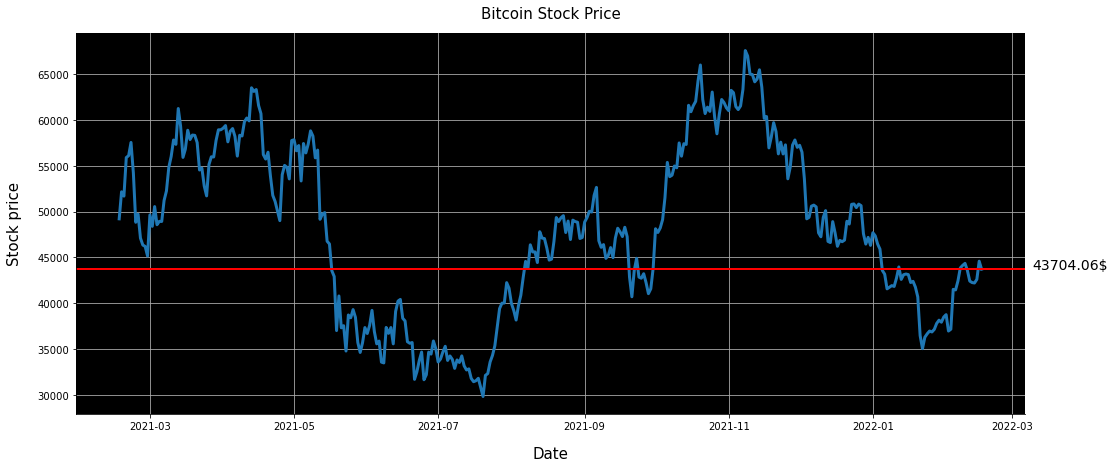

In [6]:
# Plotting "Close" values in the observing timespan

fig, ax = plt.subplots()

fig.set_size_inches(17,7)

ax.plot(df.index, df.Close, label="Bitcoin Stock Price", linewidth=3)
ax.set_title("Bitcoin Stock Price",fontsize=15, pad=15)
ax.set_xlabel("Date", fontsize=15, labelpad=15)
ax.set_ylabel("Stock price", fontsize=15, labelpad=15)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid()

ax.annotate('%0.2f' % df.Close[-1]+"$", xy=(1, df.Close[-1]), xytext=(8,0), 
            xycoords=('axes fraction', 'data'), textcoords="offset points",  fontsize=14)


ax.axhline(y=43704.06, linewidth=2, color='r')
ax.set_facecolor('black')

plt.show()

# ARIMA

In [7]:
# Set our target table for the observations
data = df["Close"]

## Decomposing 

To have an insight about the time-series' trend, seasonality and noise component.

In [8]:
decomp = seasonal_decompose(data, model="multplicative", period=30)

In [9]:
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

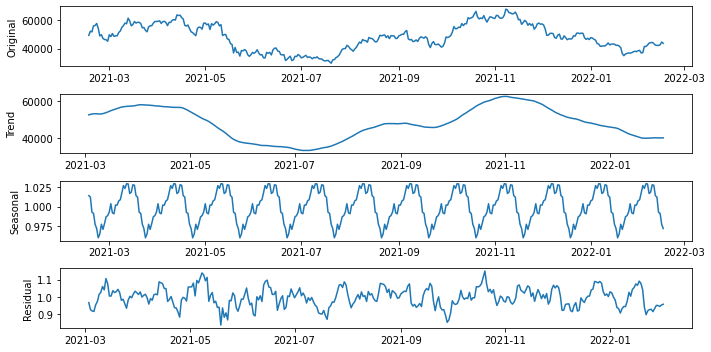

In [10]:
plt.figure(figsize=(10,5))

plt.title("Timeseries components")
plt.subplot(411)
plt.plot(data)
plt.ylabel('Original')

plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(resid)
plt.ylabel('Residual')

plt.tight_layout()

## Stationarity 

Constant mean and the variance, no trend and seasonality what makes a time-series stationary.

An easy way to find out if a timeseries is stationary to make the Augmented Dickey-Fuller test.  
If the p-value < 0,05 then it means the time series is stationary, above that value it indicates non-stationarity.

In [11]:
# ADFuller test

print("ADF stat:", adfuller(data)[0])
print("p-value:", adfuller(data)[1])
for key, value in adfuller(data)[4].items():
    print('Critial Values:')
    print(f'   {key}: {value}')

ADF stat: -1.866624253299354
p-value: 0.3479212629484274
Critial Values:
   1%: -3.4483935212959844
Critial Values:
   5%: -2.8694912343676497
Critial Values:
   10%: -2.571005879151811


In [12]:
# Checking d, the number of the differencing the time series need to be stationary for the ARIMA model 
# d = 1
ndiffs(data, test="adf")

1

In [13]:
# Differencing
diff = data.diff().dropna()

In [14]:
print("ADF stat:", adfuller(diff)[0])
print("p-value:", adfuller(diff)[1])
for key, value in adfuller(diff)[4].items():
    print('Critial Values:')
    print(f'   {key}: {value}')

ADF stat: -19.988489725177427
p-value: 0.0
Critial Values:
   1%: -3.4484434475193777
Critial Values:
   5%: -2.869513170510808
Critial Values:
   10%: -2.571017574266393


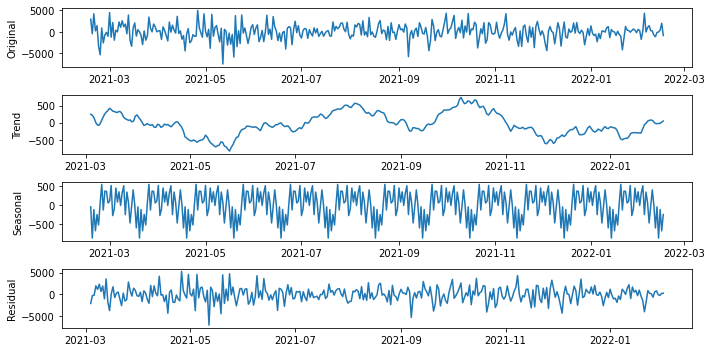

In [15]:
## Plotting the components after differencing

decomp1 = seasonal_decompose(diff, model="additive", period=30)

trend1 = decomp1.trend
seasonal1 = decomp1.seasonal
resid1 = decomp1.resid

plt.figure(figsize=(10,5))

plt.title("Timeseries components after differencing")
plt.subplot(411)
plt.plot(diff)
plt.ylabel('Original')

plt.subplot(412)
plt.plot(trend1)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(seasonal1)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(resid1)
plt.ylabel('Residual')

plt.tight_layout()


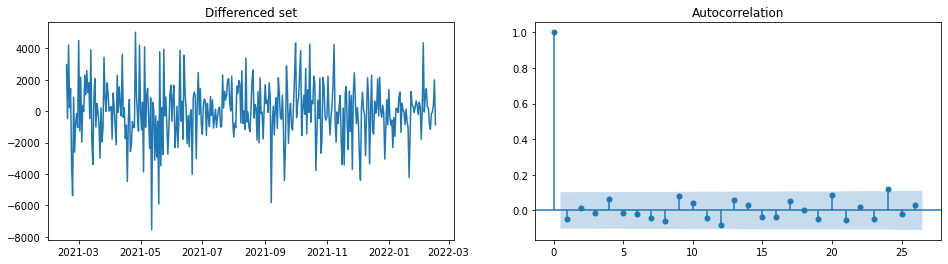

In [16]:
# The time series after differencing and the ACF plot
# From the PACF plot we can also assume the order of q, Moving Average(MA) term 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced set")
plot_acf(diff, ax=ax2);

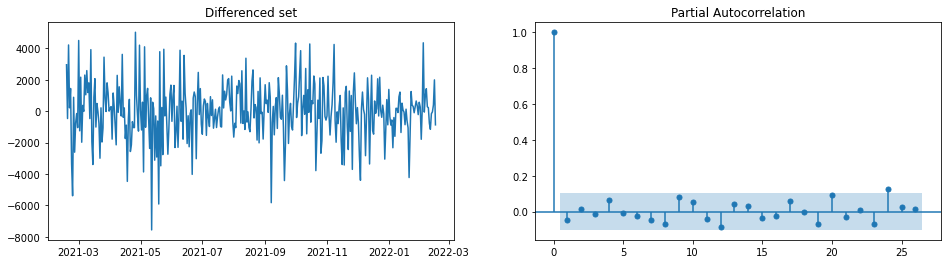

In [17]:
# The differenced plot with the PACF plot
# From the PACF plot we can also assume the order of p, Autoregression(AR) term 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced set")
plot_pacf(diff, ax=ax2);

Since the values are not above the significant line on the plots, hence according to the correlation plots we can not determine confidently the order of p and q.

## Finding the orders of ARIMA with for loop

In [18]:
import itertools

p = range(0,6)
d = range(0,2)
q = range(0,6)

pdq_comb = list(itertools.product(p,d,q))

In [19]:
len(pdq_comb)

72

In [20]:
from tqdm import tqdm

orders = []
rmse = []

for pdq in tqdm(pdq_comb):
    try:
        model = ARIMA(train, order=(pdq)).fit()
        pred = model.predict(start=len(train), end=(len(df)-1))
        error = np.sqrt(mean_squared_error(test, pred))

        orders.append(pdq)
        rmse.append(error)
        
    except:
        continue
    

100%|██████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<?, ?it/s]


In [21]:
odf = pd.DataFrame(index=orders, data=rmse, columns=["RMSE"])

In [22]:
odf.sort_values(by="RMSE").head()

,RMSE


## ARIMA model

Eventough ARIMA is an autoregressive model and can not handle seasonality, however weak stationarity is enough to the model to process the data. 

In [23]:
## Setting up our model, p=3, d=0, q=3.

train = data[:257]
test = data[257:]

model = ARIMA(train, order=(3,0,3)).fit(disp=0)

pred = model.predict(start=len(train), end=(len(data)-1))

## Evaluation - RMSE, MAPE

In [24]:
# Root mean squared error
rmse = np.sqrt(mean_squared_error(test, pred))

In [25]:
# Mean absolute percentage error
mape = round(mean_absolute_percentage_error(test, pred), 3)

In [26]:
rmse

3161.1149120374434

In [27]:
mape

0.053

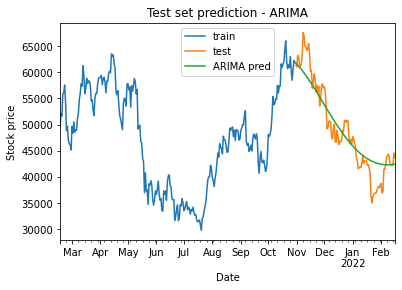

In [28]:
# Plotting the prediction results on the test set
plt.title("Test set prediction - ARIMA")

train.plot(legend=True, label="train")
test.plot(legend=True, label="test")
pred.plot(legend=True, label="ARIMA pred")

plt.xlabel("Date")
plt.ylabel("Stock price")

plt.show()

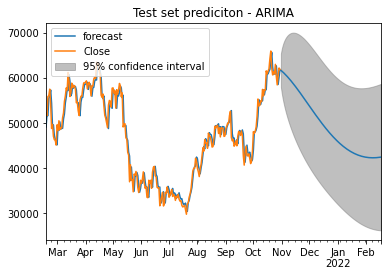

In [29]:
# Model forecast with 95% confidence interval
model.plot_predict(1, (len(df)), dynamic=False);

plt.title("Test set prediciton - ARIMA")
plt.legend(loc=2)

plt.show()

# Forecast

In [30]:
## Using the whole dataset to make the prediction for the next 100 days
final_model = ARIMA(data, order=(3,0,3)).fit(disp=0)

final_pred = final_model.predict(start=len(data), end=(len(data)+50))

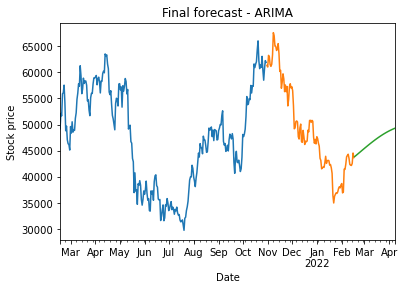

In [31]:
plt.title("Final forecast - ARIMA")
plt.xlabel("Date")
plt.ylabel("Stock price")

train.plot()
test.plot()
final_pred.plot()

plt.show()